In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
import os
from astropy.io import fits
import gc
import scipy.stats as st
import hkSpectrumLines as hsl

In [3]:
def ConsiderAndMask(fluxArray, andMaskArray):

	if (len(fluxArray) != len(andMaskArray)):
		print("Error in ConsiderAndMask: arrays not compatible.")
	else:
		fluxArray = fluxArray * (andMaskArray==0)

	return fluxArray
def Readfile(inFilename):
	"""
	Reads a Sloan Digital Sky Survey FITS file.

	IN:
	inFilename: the filename of the FITS file

	OUT:
	objectID: the ID of the astronomical object
	redShift: the redshift of the astronomical object
	dataframe: an Pandas dataframe containing the wavelength and spectral flux density series.
	"""
	# Open the FITS file read-only and store a list of Header Data Units
	HduList = fits.open(inFilename)

	# Print the HDU info
#	HduList.info()

	# Get the first header and print the keys
	priHeader = HduList[1].header #HduList['PRIMARY'].header
#	print(repr(priHeader))

	# Get spectrum data is containted in the first extension
	spectrumData = HduList[1].data 
	spectrumColumns = HduList[1].columns.names 
#	print(spectrumColumns)
	dataframe = pd.DataFrame(spectrumData, columns=spectrumColumns)

	# Get the number of records
	numRecords = len(dataframe.index)

	# Get range of wavelengths contained in the second extension
	spectrumProperties = HduList[2].data #HduList['SPECOBJ'].data
#	print(spectrumProperties.columns.names)

	minWavelength = spectrumProperties.field('WAVEMIN') # in Angstroms
	maxWavelength = spectrumProperties.field('WAVEMAX') # in Angstroms
	covWavelength = spectrumProperties.field('wCoverage') # Coverage in wavelength, in units of log10 wavelength; unsure what this is
	redShift      = spectrumProperties.field('z') # Final redshift

	objectID = ['-1']
	# Add the wavelengths to the dataframe
# 	wavelengthArray = np.logspace(start=np.log10(minWavelength), stop=np.log10(maxWavelength), num = numRecords, endpoint=True)
	wavelengthArray = np.logspace(start=np.log10(minWavelength), stop=np.log10(maxWavelength), num = numRecords, endpoint=True)
	dataframe['wavelength'] = wavelengthArray

	# Close the FITS file
	HduList.close()

	return [objectID, redShift, dataframe]

In [4]:
def NormaliseSpectra(redshiftList, objectIdList, spectrumList):
	# Create a dataframe to be sorted
	spectraDf = pd.DataFrame({'z':redshiftList, 'objID':objectIdList, 'spectrum':spectrumList})

	# Sort spectra by redshift
	spectraDf.sort_values(by='z', inplace=True)
	spectraDf.index = range(len(spectraDf.index)) # Reset the index (was also sorted)

	# Find the normalisation factors
	normalisationList = []
	oldProgress = 0.
	for index in range(len(spectraDf.index)-1):
		# Print progress
		newProgress = 100*float(index)/float(len(spectraDf.index)-1)
		if (newProgress - oldProgress > 1):
			print('   Normalising progress: {0:.0F}%...'.format(newProgress))
			oldProgress = newProgress

		# Get current and next rebinned spectra
		spectrumDf1 = spectraDf['spectrum'][index]
		spectrumDf2 = spectraDf['spectrum'][index+1]

		# Store fluxes in lists
		fluxList1 = []
		fluxList2 = []

		for flux1, flux2 in zip(spectrumDf1['flux'], spectrumDf2['flux']):
			if((flux1 != 0) and (flux2 != 0)):
				fluxList1.append(flux1)
				fluxList2.append(flux2)

		if((len(fluxList1) == 0) or (len(fluxList2) == 0)):
			print("ERROR in NormaliseSpectra: No overlapping region found.")
			print("   SpecObjectID1 = {0}; SpecObjectID2 = {1}".format(objectIdList[pointer1], objectIdList[pointer2]))

			normalisationFactor = 1.
		else:
			# Calculate the normalisation factor for spectrum 1
			normalisationFactor = np.mean(fluxList2)/np.mean(fluxList1)

		# Multiply all normalisation factors before current with the current normalisation factor
		normalisationList = [x*normalisationFactor for x in normalisationList]

		# Add the current normalisation factor
		normalisationList.append(normalisationFactor)

	# Add the normalisation factor for the last spectrum, which is 1, since all previous spectra are normalised to the last spectrum
	normalisationList.append(1.)

	# Normalise the spectra
	for index in range(len(normalisationList)):
		normalisationFactor = normalisationList[index]

		spectraDf['spectrum'][index]['flux'] = spectraDf['spectrum'][index]['flux']*normalisationFactor
		spectraDf['spectrum'][index]['ivar'] = spectraDf['spectrum'][index]['ivar']*normalisationFactor

	return spectraDf

def ToEmittedFrame(z, measuredFrame):
	"""
	Converts the wavelengthArray to its emitted spectrum

	IN:
	z: redshift
	measuredFrame: the measured wavelengths

	OUT:
	emittedFrame: the wavelengths in the emitted frame
	"""

	emittedFrame = measuredFrame / (1+z)
	return emittedFrame
def ReBinData(spectrumList, binSize, startWavelength, stopWavelength, method = "AM"):
	"""
	Re-bins data.

	IN:
	spectrumList: list with spectra.
	binSize: new size of bins
	startWavelength: new start wavelength
	endWavelength: new end wavelenght
	method: method for combining spectra

	OUT:
	compositeDf: dataframe containing the composite spectrum
	"""
	newWavelengthArray = np.arange(start=startWavelength, stop=stopWavelength, step = binSize)
	arrayLength = len(newWavelengthArray)

	newFluxArray = np.zeros(shape=arrayLength)
	newUncFluxArray = np.zeros(shape=arrayLength)
	newNoiseFluxArray =  np.zeros(shape=arrayLength)
	newNumDataArray =  np.zeros(shape=arrayLength)

	# Define indices on the destination arrays
# 	oldProgress = 0.
	for i in range(arrayLength):
		# Print progress
# 		newProgress = 100*float(index)/float(arrayLength)
# 		if (newProgress - oldProgress > 1):
# 			print('   Rebinning progress: {0:.0F}%...'.format(newProgress),flush=True)
# 			oldProgress = newProgress

		# Calculate bin boundaries
		lowerWavelength = newWavelengthArray[i] # - binSize/2.
		upperWavelength = newWavelengthArray[i] + binSize # + binSize/2.

		# Fill temporary arrays
		tempFluxArray = np.array([])
		tempIvarArray = np.array([])
		for spectrumDf in spectrumList:
			condition1 = (spectrumDf['wavelength'] >= lowerWavelength)
			condition2 = (spectrumDf['wavelength'] <  upperWavelength)
			tempFluxArray = np.append(tempFluxArray, spectrumDf['flux'][condition1 & condition2])
			tempIvarArray = np.append(tempIvarArray, spectrumDf['ivar'][condition1 & condition2])

		# Calculate mean flux, uncertainty and noise
		mean_f_lambda  = 0.
		unc_f_lambda   = 0.
		noise_f_lambda = 0.
		n_data = len(tempFluxArray)

		if(n_data == 0):
			print("ERROR in ReBinData: No data in bin {0:.0F} - {1:.0F}".format(lowerWavelength, upperWavelength))

		elif(n_data == 1):
			print("WARNING in ReBinData: One data point only in bin {0:.0F} - {1:.0F}".format(lowerWavelength, upperWavelength))

			mean_f_lambda  = tempFluxArray[0]
			noise_f_lambda = 1./tempIvarArray[0]
			unc_f_lambda   = 0.

		else:
			# Calculate the uncertainty of the mean value
			unc_f_lambda = np.std(a=tempFluxArray, ddof=1)/np.sqrt(float(n_data))

			if(method.upper() == 'GM'):
				# Set all values <0 to 1
				tempFluxArray[tempFluxArray<=0] = 1.

				# Calculate the geometric mean flux
				mean_f_lambda = st.gmean(tempFluxArray)

				# Calculate the the noise of the mean value
				noise_f_lambda = mean_f_lambda/float(n_data) * np.sqrt(np.sum((1./tempIvarArray)/mean_f_lambda))

			else:
				# Calculate the arithmetric mean flux
				mean_f_lambda = np.mean(tempFluxArray)

				# Calculate the noise of the mean value
				noise_f_lambda = 1./float(n_data) * np.sqrt(np.sum(1./tempIvarArray))

		# Store calculated values
		newFluxArray[i] = mean_f_lambda
		newUncFluxArray[i] = unc_f_lambda
		newNoiseFluxArray[i] = noise_f_lambda
		newNumDataArray[i] = n_data

	# Return the composite spectrum in a dataframe
	compositeDf = pd.DataFrame({'wavelength':newWavelengthArray, 'mean_f_lambda':newFluxArray, 'noise_f_lambda':newNoiseFluxArray, 'unc_f_lambda':newUncFluxArray, 'n_data':newNumDataArray})
	return compositeDf

def CompositeSpectrum(filenameList = [], wavelengthRange = (), binSize = 4., method = "AM"):

	# Open each fits file and retrieve and store redshift
	objectIdList = []
	redshiftList = []
	spectrumList = []

	minWavelengthList = []
	maxWavelengthList = []

	# Load data
	print("Reading {0} FITS files...".format(len(filenameList)))
	for filename in filenameList:
# 		print("Processing: " + filename +"...")
		# Open file
		HduList = fits.open(filename)

		# Get spectrum data is containted in the first extension
		spectrumData = HduList[1].data.copy() #HduList['COADD'].data
		spectrumColumns = HduList[1].columns.names.copy() #HduList['COADD'].columns.names
		spectrumDf = pd.DataFrame(spectrumData, columns=spectrumColumns)

		# Get the number of records
		numRecords = len(spectrumDf.index)

		# Get range of wavelengths contained in the second extension
		spectrumProperties = HduList[2].data.copy() #HduList['SPECOBJ'].data

		try:
			minWavelength = float(spectrumProperties.field('WAVEMIN')) # in Angstrom
			maxWavelength = float(spectrumProperties.field('WAVEMAX')) # in Angstrom
			covWavelength = float(spectrumProperties.field('wCoverage')) # Coverage in wavelength, in units of log10 wavelength; unsure what this is
			redShift      = float(spectrumProperties.field('z')) # Final redshift
			objectId      = str(spectrumProperties.field('SPECOBJID')) # Object ID
		except KeyError:
			print("ERROR in CompositeSpectrum: Could not retrieve spectrum property...")
			print(HduList[2].columns.names)
			raise KeyError


		del HduList[1].data
		del HduList[2].data

		# Close fits file
		HduList.close()

		# Enforce garbage collection
		gc.collect()

		# Create a wavelength array and add it to the dataframe
		wavelengthArray = np.logspace(start=np.log10(minWavelength), stop=np.log10(maxWavelength), num = numRecords, endpoint=True)
		spectrumDf['wavelength'] = wavelengthArray

		# Transform min / max wavelengths to emitted frame
		minWavelength = minWavelength/(1+redShift)
		maxWavelength = maxWavelength/(1+redShift)

		# Store all in lists
		minWavelengthList.append(minWavelength)
		maxWavelengthList.append(maxWavelength)

		objectIdList.append(objectId)
		redshiftList.append(redShift)
		spectrumList.append(spectrumDf)

	# Determine minimum and maximum wavelengths to use for rebinning
	if (len(wavelengthRange)<2):
		# Create a proper start and end wavelength based on the info in the FITS files
		minWavelength = min(minWavelengthList)
		maxWavelength = max(maxWavelengthList)

#		minWavelength = int(minWavelength/500)*500.0
#		maxWavelength = (int(maxWavelength/500)+1)*500.0
	else:
		# Use given range
		minWavelength = min(wavelenghRange)
		maxWavelength = max(wavelenghRange)

	print("Wavelength range: [{0:.3G}, {1:.3G}]".format(minWavelength, maxWavelength))

	# Correct for redshift
	print("Correcting for redshift...")
	for z, spectrumDf in zip(redshiftList, spectrumList):
		# Correct for redshift
		spectrumDf['wavelength'] = ToEmittedFrame(z, spectrumDf['wavelength'])

	# Remove bad data
	print("Removing bad data...")
	for spectrumDf in spectrumList:
		# Zero all suspicious data
		spectrumDf['flux'] = ConsiderAndMask(spectrumDf['flux'], spectrumDf['and_mask'])

	# Normalise the spectra
	print("Calculating normalisation factors...")
	normalisedDf = NormaliseSpectra(redshiftList, objectIdList, spectrumList)
    
	del spectrumList

	# Combine the individual spectra to a single composite spectrum
	print("Rebinning data and creating composite...")
	compositeDf = ReBinData(normalisedDf['spectrum'], binSize, minWavelength, maxWavelength, method)

	# Return the composite spectrum
	return compositeDf

In [23]:
foldername = "F:\学习\天体物理\data part\\"

# Store the names of fits-files
filenameList = []
for filename in os.listdir(foldername):
    if (filename.endswith(".fits") or filename.endswith(".FITS")):
        filenameList.append(foldername + filename)

# Create the composite spectrum
compositeSpectrum = CompositeSpectrum(filenameList, binSize = 4., method="GM")

filename = 'F:\学习\天体物理\CompositeSpec.csv'
print("Writing composite spectrum to " + filename)
compositeSpectrum.to_csv(filename, index=False)
print("Done...")

Reading 33 FITS files...
Wavelength range: [681, 1.03E+04]
Correcting for redshift...
Removing bad data...
Calculating normalisation factors...
   Normalising progress: 3%...
   Normalising progress: 6%...
   Normalising progress: 9%...
   Normalising progress: 12%...
   Normalising progress: 16%...
   Normalising progress: 19%...
   Normalising progress: 22%...
   Normalising progress: 25%...
   Normalising progress: 28%...
   Normalising progress: 31%...
   Normalising progress: 34%...
   Normalising progress: 38%...
   Normalising progress: 41%...
   Normalising progress: 44%...
   Normalising progress: 47%...
   Normalising progress: 50%...
   Normalising progress: 53%...
   Normalising progress: 56%...
   Normalising progress: 59%...
   Normalising progress: 62%...
   Normalising progress: 66%...
   Normalising progress: 69%...
   Normalising progress: 72%...
   Normalising progress: 75%...
   Normalising progress: 78%...
   Normalising progress: 81%...
   Normalising progress: 84

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in true_divide
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in sqrt


WARNING in ReBinData: One data point only in bin 10337 - 10341
Writing composite spectrum to F:\学习\天体物理\CompositeSpec.csv
Done...


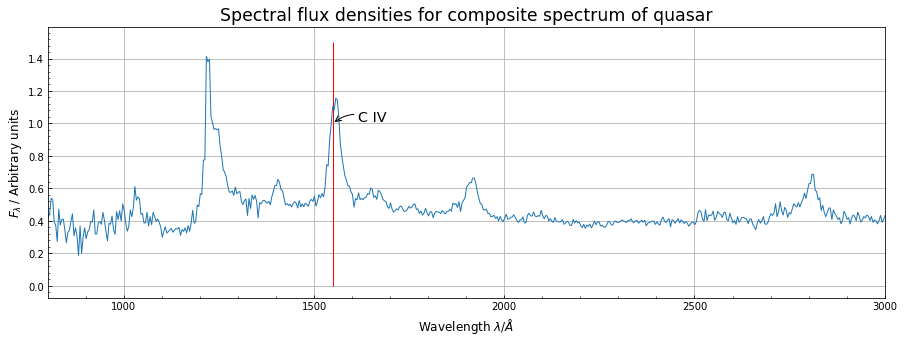

In [57]:
compositeSpectrum = pd.read_csv('F:\学习\天体物理\CompositeSpec.csv', skiprows=0)

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(111)
ax0.plot(compositeSpectrum['wavelength'], compositeSpectrum['mean_f_lambda'], linewidth=1)
# hsl.PlotSpectrumLines(ax0,[r'C IV'], 14)
ax0.set_xlabel('Wavelength $\lambda / \AA$', fontsize='large')
ax0.set_ylabel('$F_{\lambda} \, / $ Arbitrary units', fontsize='large')
ax0.set_title('Spectral flux densities for composite spectrum of quasar', fontsize='xx-large')
ax0.grid(True)
ax0.vlines(1549.05,0,1.5, color = 'r', linestyle = '-', linewidth = 1)
ax0.annotate('C IV', xy=(1549.5, 1), arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.3'), xytext=(25, 2), xycoords = 'data',textcoords='offset points', fontsize='x-large')
xMajorLocator = tic.MultipleLocator(500)
xMinorLocator = tic.AutoMinorLocator(5)
ax0.xaxis.set_major_locator(xMajorLocator)
ax0.xaxis.set_minor_locator(xMinorLocator)
yMinorLocator = tic.AutoMinorLocator(5)
ax0.yaxis.set_minor_locator(yMinorLocator)
ax0.tick_params(which = 'both', direction = 'in')
ax0.set_xlim(800,3000)
plt.show()